# The Fundamentals of Autograd | Autograd 的基础知识

请观看下面或[YouTube](https://www.youtube.com/watch?v=M0fX15_-xrY)上的视频。

PyTorch 的`Autograd`功能是 PyTorch 灵活快速地构建机器学习项目的一部分。它允许在复杂的计算中快速、轻松地计算多个偏导数（也称为梯度）。此操作是基于反向传播的神经网络学习的核心。

autograd 的强大之处在于它在运行时动态跟踪您的计算，这意味着如果您的模型有决策分支或循环，其长度直到运行时才知道，计算仍然会被正确跟踪，并且您将得到正确的结果梯度来驱动学习。再加上您的模型是用 Python 构建的，与依赖于更严格结构的模型的静态分析来计算梯度的框架相比，它提供了更大的灵活性。

## What Do We Need Autograd For? 我们需要 Autograd 做什么？

机器学习模型是一个具有输入和输出的函数。在本次讨论中，我们将输入视为 i 维向量 $\vec{x}$，有元素 $x_i$。然后我们可以将模型$M$表示为输入的向量值函数: $\vec{y} = \vec{M}(\vec{x})$。我们将 M 的输出值视为向量，因为一般来说，模型可能有任意数量的输出。）

由于我们主要在训练的背景下讨论 autograd， 我们感兴趣的输出将是模型的损失。损失函数$\text{L}(\vec{y}) = \text{L}(\vec{M}(\vec{x}))$，是模型输出的单值标量函数。该函数表示我们的模型的预测与特定输入的理想输出的差距有多大。注意：在此之后，我们通常会省略矢量符号，因为它应该在上下文中明确。例如 $y$,而不是$\vec{y}$。

在训练模型时，我们希望最小化损失。在完美模型的理想情况下，这意味着调整其学习权重 - 即函数的可调整参数 - 使得所有输入的损失为零。在现实世界中，这意味着一个不断调整学习权重的迭代过程，直到我们看到对于各种输入我们得到了可以容忍的损失。


我们如何决定调整权重的距离和方向？我们 想要最小化损失，这意味着使其相对于输入的一阶导数等于 0： $\frac{\partial L}{\partial x} = 0$

不过，请记住，损失不是直接从输入导出的，而是模型输出的函数（直接是输入的函数），$\frac{\partial L}{\partial x} = \frac{\partial L(\vec{y})}{\partial x}$，根据微分学的链式法则，我们有：$\frac{\partial L(\vec{y})}{\partial x} = \frac{\partial L}{\partial y} \frac{\partial y}{\partial x} = \frac{\partial L}{\partial y} \frac{\partial M(x)}{\partial x}$

$\frac{\partial M(x)}{\partial x}$ 这就是事情变得复杂的地方。如果我们再次使用链式法则扩展表达式，模型输出相对于输入的偏导数将涉及模型中每个相乘的学习权重、每个激活函数以及每个其他数学变换的许多局部偏导数。每个此类偏导数的完整表达式是通过计算图的每个可能路径的局部梯度的乘积之和，该计算图以我们试图测量其梯度的变量结尾。

特别是，我们对学习权重的梯度——要求改变每个权重的方向以使损失函数更接近于零。

由于此类局部导数（每个导数对应于模型计算图中的一条单独路径）的数量往往会随着神经网络的深度呈指数增长，因此计算它们的复杂性也会随之增加。这就是 autograd 发挥作用的地方：它跟踪每次计算的历史记录。 PyTorch 模型中的每个计算张量都带有其输入张量和用于创建它的函数的历史记录。结合 PyTorch 函数旨在作用于张量的事实，每个函数都有一个用于计算自己的导数的内置实现，这大大加快了学习所需的局部导数的计算速度。

## A Simple Example 一个简单的例子

这是很多理论 - 但在实践中使用 autograd 是什么样子呢

让我们从一个简单的例子开始。首先，我们将进行一些导入以绘制结果：

In [1]:
# %matplotlib inline

import torch

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import math

接下来，我们将创建一个输入张量，其中充满均匀间隔的值 间隔，并指定`requires_grad=True` 。 （与大多数创建张量的函数一样， `torch.linspace()`接受可选的`requires_grad`选项。）设置此标志意味着在接下来的每个计算中，`autograd` 将在该计算的输出张量中累积计算的历史记录。

In [2]:
a = torch.linspace(0., 2. * math.pi, steps=25, requires_grad=True)
print(a)

tensor([0.0000, 0.2618, 0.5236, 0.7854, 1.0472, 1.3090, 1.5708, 1.8326, 2.0944,
        2.3562, 2.6180, 2.8798, 3.1416, 3.4034, 3.6652, 3.9270, 4.1888, 4.4506,
        4.7124, 4.9742, 5.2360, 5.4978, 5.7596, 6.0214, 6.2832],
       requires_grad=True)


接下来，我们将执行计算，并根据输入绘制其输出：

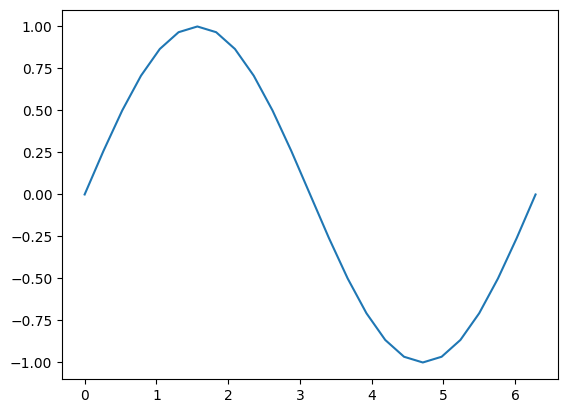

In [3]:
b = torch.sin(a)
plt.plot(a.detach(), b.detach())

让我们仔细看看张量b 。当我们打印它时，我们会看到一个指示符，表明它正在跟踪其计算历史记录：

In [4]:
print(b)

tensor([ 0.0000e+00,  2.5882e-01,  5.0000e-01,  7.0711e-01,  8.6603e-01,
         9.6593e-01,  1.0000e+00,  9.6593e-01,  8.6603e-01,  7.0711e-01,
         5.0000e-01,  2.5882e-01, -8.7423e-08, -2.5882e-01, -5.0000e-01,
        -7.0711e-01, -8.6603e-01, -9.6593e-01, -1.0000e+00, -9.6593e-01,
        -8.6603e-01, -7.0711e-01, -5.0000e-01, -2.5882e-01,  1.7485e-07],
       grad_fn=<SinBackward0>)


这个`grad_fn`给了我们一个提示，当我们执行反向传播步骤并计算梯度时，我们需要计算对于该张量的所有输入。

让我们执行更多计算：

In [5]:
c = 2 * b
print(c)

d = c + 1
print(d)

tensor([ 0.0000e+00,  5.1764e-01,  1.0000e+00,  1.4142e+00,  1.7321e+00,
         1.9319e+00,  2.0000e+00,  1.9319e+00,  1.7321e+00,  1.4142e+00,
         1.0000e+00,  5.1764e-01, -1.7485e-07, -5.1764e-01, -1.0000e+00,
        -1.4142e+00, -1.7321e+00, -1.9319e+00, -2.0000e+00, -1.9319e+00,
        -1.7321e+00, -1.4142e+00, -1.0000e+00, -5.1764e-01,  3.4969e-07],
       grad_fn=<MulBackward0>)
tensor([ 1.0000e+00,  1.5176e+00,  2.0000e+00,  2.4142e+00,  2.7321e+00,
         2.9319e+00,  3.0000e+00,  2.9319e+00,  2.7321e+00,  2.4142e+00,
         2.0000e+00,  1.5176e+00,  1.0000e+00,  4.8236e-01, -3.5763e-07,
        -4.1421e-01, -7.3205e-01, -9.3185e-01, -1.0000e+00, -9.3185e-01,
        -7.3205e-01, -4.1421e-01,  4.7684e-07,  4.8236e-01,  1.0000e+00],
       grad_fn=<AddBackward0>)


最后，让我们计算单元素输出。当您在不带参数的张量上调用`.backward()`时，它期望调用张量仅包含单个元素，就像计算损失函数时的情况一样。

In [6]:
out = d.sum()
print(out)

tensor(25., grad_fn=<SumBackward0>)


与张量一起存储的每个`grad_fn`都允许您使用其`next_functions`属性将计算一直返回到其输入。我们可以在下面看到，深入研究`d`上的这个属性向我们展示了所有先验张量的梯度函数。请注意， `a.grad_fn`报告为`None` ，表明这是函数的输入，没有自己的历史记录。

In [7]:
print('d:')
print(d.grad_fn)
print(d.grad_fn.next_functions)
print(d.grad_fn.next_functions[0][0].next_functions)
print(d.grad_fn.next_functions[0][0].next_functions[0][0].next_functions)
print(d.grad_fn.next_functions[0][0].next_functions[0][0].next_functions[0][0].next_functions)
print('\nc:')
print(c.grad_fn)
print('\nb:')
print(b.grad_fn)
print('\na:')
print(a.grad_fn)

d:
((<MulBackward0 object at 0x127897d30>, 0), (None, 0))
((<SinBackward0 object at 0x127896d10>, 0), (None, 0))
((<AccumulateGrad object at 0x127897cd0>, 0),)
()

c:

b:

a:
None


有了所有这些机制，我们如何推出衍生品呢？您对输出调用`backward()`方法，并检查输入的grad属性以检查渐变：

tensor([ 2.0000e+00,  1.9319e+00,  1.7321e+00,  1.4142e+00,  1.0000e+00,
         5.1764e-01, -8.7423e-08, -5.1764e-01, -1.0000e+00, -1.4142e+00,
        -1.7321e+00, -1.9319e+00, -2.0000e+00, -1.9319e+00, -1.7321e+00,
        -1.4142e+00, -1.0000e+00, -5.1764e-01,  2.3850e-08,  5.1764e-01,
         1.0000e+00,  1.4142e+00,  1.7321e+00,  1.9319e+00,  2.0000e+00])


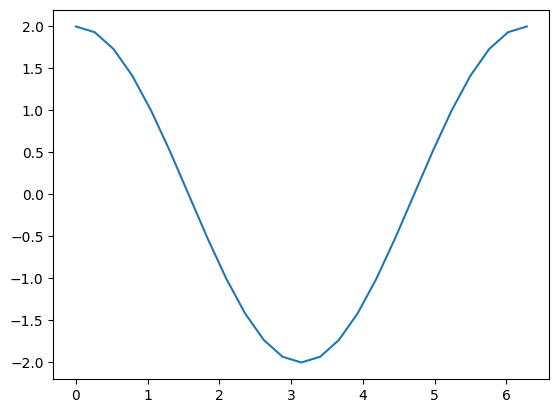

In [8]:
out.backward()
print(a.grad)
plt.plot(a.detach(), a.grad.detach())

回想一下我们达到这里所采取的计算步骤：

In [9]:
a = torch.linspace(0., 2. * math.pi, steps=25, requires_grad=True)
b = torch.sin(a)
c = 2 * b
d = c + 1
out = d.sum()

添加一个常数（就像我们计算`d`一样）不会改变导数。那$c = 2 \cdot b = 2 \cdot \sin(a)$ 其导数应该是 $2 \cdot \cos(a)$ 看看上面的图表，这就是我们所看到的。

请注意，只有计算的叶节点才会计算其梯度。例如，如果您尝试`print(c.grad)`您会得到None 。在这个简单的示例中，只有输入是叶节点，因此只有它计算了梯度。

In [10]:
print(c.grad)

None


/var/folders/h_/hd08bvxx70ddd432k315jhww0000gn/T/ipykernel_85821/3425888651.py:1: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(c.grad)


## Autograd in Training 训练中的Autograd

我们已经简要了解了 autograd 的工作原理，但是当它用于其预期目的时，它会是什么样子呢？让我们定义一个小模型并检查它在单个训练批次后如何变化。首先，定义一些常量、模型以及输入和输出：

In [11]:
BATCH_SIZE = 16
DIM_IN = 1000
HIDDEN_SIZE = 100
DIM_OUT = 10

class TinyModel(torch.nn.Module):

    def __init__(self):
        super(TinyModel, self).__init__()

        self.layer1 = torch.nn.Linear(DIM_IN, HIDDEN_SIZE)
        self.relu = torch.nn.ReLU()
        self.layer2 = torch.nn.Linear(HIDDEN_SIZE, DIM_OUT)

    def forward(self, x):
        x = self.layer1(x)
        x = self.relu(x)
        x = self.layer2(x)
        return x

some_input = torch.randn(BATCH_SIZE, DIM_IN, requires_grad=False)
ideal_output = torch.randn(BATCH_SIZE, DIM_OUT, requires_grad=False)

model = TinyModel()

您可能会注意到的一件事是，我们从未为模型的层指定`requires_grad=True` 。在`torch.nn.Module`的子类中，认为我们想要跟踪层权重的梯度以进行学习，自动为所有参数设置`requires_grad=True`。

如果我们查看模型的各层，我们可以检查权重的值，并验证尚未计算任何梯度：

In [12]:
print(model)
print(model.layer2)
print(model.layer2.weight.shape)
print(model.layer2.weight[0][0:10]) # just a small slice
print(model.layer2.weight.grad)

TinyModel(
  (layer1): Linear(in_features=1000, out_features=100, bias=True)
  (relu): ReLU()
  (layer2): Linear(in_features=100, out_features=10, bias=True)
)
Linear(in_features=100, out_features=10, bias=True)
torch.Size([10, 100])
tensor([ 0.0108,  0.0305,  0.0288, -0.0466, -0.0928, -0.0545,  0.0659, -0.0670,
        -0.0027, -0.0107], grad_fn=<SliceBackward0>)
None


让我们看看当我们运行一批训练时，情况会发生怎样的变化。对于损失函数，我们将仅使用`prediction`和`ideal_output`之间的欧几里德距离的平方，并且我们将使用基本的随机梯度下降优化器。

In [13]:
optimizer = torch.optim.SGD(model.parameters(), lr=0.001)

prediction = model(some_input)

loss = (ideal_output - prediction).pow(2).sum()
print(loss)

tensor(149.1543, grad_fn=<SumBackward0>)


现在，让我们调用`loss.backward()`看看会发生什么：

In [14]:
loss.backward()
print(model.layer2.weight[0][0:10])
print(model.layer2.weight.grad[0][0:10])

tensor([ 0.0108,  0.0305,  0.0288, -0.0466, -0.0928, -0.0545,  0.0659, -0.0670,
        -0.0027, -0.0107], grad_fn=<SliceBackward0>)
tensor([-1.8035, -5.4541,  0.6110,  3.5332, -0.1365, -1.6221,  2.0773, -0.4618,
        -1.2684,  1.4749])


我们可以看到每个学习权重的梯度都已计算出来，但权重保持不变，因为我们还没有运行优化器。优化器负责根据计算的梯度更新模型权重。

In [15]:
optimizer.step()
print(model.layer2.weight[0][0:10])
print(model.layer2.weight.grad[0][0:10])

tensor([ 0.0126,  0.0360,  0.0282, -0.0501, -0.0927, -0.0528,  0.0638, -0.0665,
        -0.0014, -0.0122], grad_fn=<SliceBackward0>)
tensor([-1.8035, -5.4541,  0.6110,  3.5332, -0.1365, -1.6221,  2.0773, -0.4618,
        -1.2684,  1.4749])


您应该看到`layer2`的权重已更改。

这个过程中一件重要的事情是：调用`optimizer.step()`之后，你需要调用`optimizer.zero_grad()` ，否则每次运行`loss.backward()`时，学习权重的梯度都会累积：

In [16]:
print(model.layer2.weight.grad[0][0:10])

for i in range(0, 5):
    prediction = model(some_input)
    loss = (ideal_output - prediction).pow(2).sum()
    loss.backward()

print(model.layer2.weight.grad[0][0:10])

optimizer.zero_grad(set_to_none=False)

print(model.layer2.weight.grad[0][0:10])

tensor([-1.8035, -5.4541,  0.6110,  3.5332, -0.1365, -1.6221,  2.0773, -0.4618,
        -1.2684,  1.4749])
tensor([ -8.8157, -32.2040,  -3.9283,  22.5840,   8.4617,  -6.7331,   1.3191,
         -3.6947,   8.3756,  14.3949])
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])


运行上面的单元格后，您应该看到多次运行`loss.backward()`后，大多数梯度的幅度都会大得多。在运行下一个训练批次之前未能将梯度归零将导致梯度以这种方式爆炸，从而导致不正确且不可预测的学习结果

## Turning Autograd Off and On 关闭和打开 Autograd

在某些情况下，您需要对是否启用自动分级进行细粒度控制。根据具体情况，有多种方法可以做到这一点。

最简单的方法是直接更改张量上的`requires_grad`标志：

In [17]:
a = torch.ones(2, 3, requires_grad=True)
print(a)

b1 = 2 * a
print(b1)

a.requires_grad = False
b2 = 2 * a
print(b2)

tensor([[1., 1., 1.],
        [1., 1., 1.]], requires_grad=True)
tensor([[2., 2., 2.],
        [2., 2., 2.]], grad_fn=<MulBackward0>)
tensor([[2., 2., 2.],
        [2., 2., 2.]])


在上面的单元格中，我们看到`b1`有一个`grad_fn` （即，跟踪的计算历史），这正是我们所期望的，因为它是从打开了 `autograd` 的张量`a`导出的。当我们使用`a.requires_grad = False`显式关闭 `autograd` 时，将不再跟踪计算历史记录，正如我们在计算`b2`时所看到的那样。

如果您只需要暂时关闭 `autograd`，更好的方法是使用`torch.no_grad()` ：

In [18]:
a = torch.ones(2, 3, requires_grad=True) * 2
b = torch.ones(2, 3, requires_grad=True) * 3

c1 = a + b
print(c1)

with torch.no_grad():
    c2 = a + b

print(c2)

c3 = a * b
print(c3)

tensor([[5., 5., 5.],
        [5., 5., 5.]], grad_fn=<AddBackward0>)
tensor([[5., 5., 5.],
        [5., 5., 5.]])
tensor([[6., 6., 6.],
        [6., 6., 6.]], grad_fn=<MulBackward0>)


`torch.no_grad()`也可以用作函数或方法装饰器：

In [19]:
def add_tensors1(x, y):
    return x + y

@torch.no_grad()
def add_tensors2(x, y):
    return x + y


a = torch.ones(2, 3, requires_grad=True) * 2
b = torch.ones(2, 3, requires_grad=True) * 3

c1 = add_tensors1(a, b)
print(c1)

c2 = add_tensors2(a, b)
print(c2)

tensor([[5., 5., 5.],
        [5., 5., 5.]], grad_fn=<AddBackward0>)
tensor([[5., 5., 5.],
        [5., 5., 5.]])


有一个相应的上下文管理器`torch.enable_grad()` ，用于在尚未打开 `autograd` 时打开它。它也可以用作装饰器。

In [20]:
import torch
import torch.nn as nn

# 定义一个简单的模型
model = nn.Linear(10, 1)
input_data = torch.randn(1, 10)  # 输入是一个形状为 (1, 10) 的张量

# 默认情况下梯度是启用的
output = model(input_data)
print("Default (Grad enabled):", torch.is_grad_enabled())  # 输出: True
print("Output requires grad:", output.requires_grad)  # 输出: True

# 在 torch.no_grad() 中禁用梯度计算
with torch.no_grad():
    output_no_grad = model(input_data)
    print("\ntorch.no_grad() (Grad disabled):", torch.is_grad_enabled())  # 输出: False
    print("Output requires grad:", output_no_grad.requires_grad)  # 输出: False

    # 在 torch.enable_grad() 中重新启用梯度计算
    with torch.enable_grad():
        output_with_grad = model(input_data)
        print("\ntorch.enable_grad() within no_grad (Grad enabled again):", torch.is_grad_enabled())  # 输出: True
        print("Output requires grad:", output_with_grad.requires_grad)  # 输出: True

Default (Grad enabled): True
Output requires grad: True

torch.no_grad() (Grad disabled): False
Output requires grad: False

torch.enable_grad() within no_grad (Grad enabled again): True
Output requires grad: True


In [21]:
# 默认情况下，梯度计算是启用的
print("Default grad enabled:", torch.is_grad_enabled())  # 输出: True

# 手动禁用梯度计算
torch.set_grad_enabled(False)
print("Grad disabled manually:", torch.is_grad_enabled())  # 输出: False

# 使用 torch.enable_grad() 单独启用梯度计算
with torch.enable_grad():
    print("Grad enabled with torch.enable_grad():", torch.is_grad_enabled())  # 输出: True

Default grad enabled: True
Grad disabled manually: False
Grad enabled with torch.enable_grad(): True


最后，您可能有一个需要梯度跟踪的张量，但您想要一个不需要梯度跟踪的副本。为此，我们有Tensor对象的`detach()`方法 - 它创建与计算历史分离的张量的副本：

In [22]:
x = torch.rand(5, requires_grad=True)
y = x.detach()

print(x)
print(y)

tensor([0.5006, 0.4851, 0.5482, 0.9520, 0.6688], requires_grad=True)
tensor([0.5006, 0.4851, 0.5482, 0.9520, 0.6688])


当我们想要绘制一些张量的图表时，我们就这样做了。这是因为matplotlib需要 NumPy 数组作为输入，并且对于 require_grad=True 的张量，不会启用从 PyTorch 张量到 NumPy 数组的隐式转换。制作一份独立的副本可以让我们继续运行。

## Autograd and In-place Operations Autograd 和就地操作

到目前为止，在notebook的每个示例中，我们都使用变量来捕获计算的中间值。 Autograd 需要这些中间值来执行梯度计算。因此，在使用 autograd 时必须小心使用就地操作。这样做可能会破坏在`backward()`调用中计算导数所需的信息。如果您尝试对需要自动分级的叶变量进行就地操作，PyTorch 甚至会阻止您，如下所示。

> ### NOTE
> 以下代码单元引发运行时错误。这是预料之中的。
> ```python
> a = torch.linspace(0., 2. * math.pi, steps=25, requires_grad=True)
> torch.sin_(a)
> ```

## Autograd Profiler Autograd 分析器

Autograd 详细跟踪计算的每一步。这样的计算历史记录与计时信息相结合，将成为一个方便的分析器 - 并且 autograd 具有该功能。下面是一个快速示例用法：

分析器还可以标记各个代码子块，按输入张量形状分解数据，并将数据导出为 Chrome 跟踪工具文件。有关 API 的完整详细信息，请参阅[文档](https://pytorch.org/docs/stable/autograd.html#profiler)。

In [23]:
import torch
import torch.nn as nn

# 检查可用的设备
device = torch.device('cpu')
run_on_gpu = False

if torch.cuda.is_available():
    device = torch.device('cuda')
    run_on_gpu = True
elif torch.backends.mps.is_available():
    device = torch.device('mps')
    run_on_gpu = False  # MPS 使用时，不支持 use_cuda=True

# 定义一个简单的卷积层并将其移动到目标设备
conv = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1).to(device)

# 创建输入张量并将其移动到相同的设备
input_tensor = torch.randn(10, 3, 32, 32).to(device)  # batch size of 10, 3 channels, 32x32 image

# 根据设备选择是否使用 GPU 或 CPU
with torch.autograd.profiler.profile(use_cuda=run_on_gpu) as prf:
    for _ in range(10000):
        output = conv(input_tensor)  # 执行卷积操作

print(prf.key_averages().table(sort_by='self_cpu_time_total'))

STAGE:2024-09-29 11:29:14 85821:13572098 ActivityProfilerController.cpp:314] Completed Stage: Warm Up
STAGE:2024-09-29 11:29:15 85821:13572098 ActivityProfilerController.cpp:320] Completed Stage: Collection
STAGE:2024-09-29 11:29:15 85821:13572098 ActivityProfilerController.cpp:324] Completed Stage: Post Processing


--------------------------  ------------  ------------  ------------  ------------  ------------  ------------  
                      Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg    # of Calls  
--------------------------  ------------  ------------  ------------  ------------  ------------  ------------  
    aten::_mps_convolution        82.64%     453.106ms        82.76%     453.731ms      45.373us         10000  
         aten::convolution         6.44%      35.320ms        85.66%     469.668ms      46.967us         10000  
        aten::_convolution         6.40%      35.103ms        84.63%     464.025ms      46.403us         10000  
              aten::conv2d         4.40%      24.114ms        86.38%     473.581ms      47.358us         10000  
               aten::empty         0.06%     332.000us         0.06%     332.000us       0.033us         10000  
                aten::view         0.05%     293.000us         0.05%     293.000us       0.029us

## Advanced Topic: More Autograd Detail and the High-Level API 高级主题：更多 Autograd 详细信息和高级 API

如果你有一个 n 维输入和 m 维输出的函数，$\vec{y} = f(\vec{x})$，那么完整的梯度是一个矩阵，其元素为每个输出对每个输入的导数，这个矩阵被称为雅可比矩阵（Jacobian）：

$$
J = \begin{pmatrix}
\frac{\partial y_1}{\partial x_1} & \cdots & \frac{\partial y_1}{\partial x_n} \\
\vdots & \ddots & \vdots \\
\frac{\partial y_m}{\partial x_1} & \cdots & \frac{\partial y_m}{\partial x_n}
\end{pmatrix}
$$

如果你有第二个函数，$l = g(\vec{y})$，它接受一个 m 维输入（即与上面输出相同的维度），并返回一个标量输出，你可以将其相对于 $\vec{y}$ 的梯度表示为一个列向量，$\vec{v} = \left( \frac{\partial l}{\partial y_1} \quad \cdots \quad \frac{\partial l}{\partial y_m} \right)^{T}$，这实际上只是一个单列的雅可比矩阵。

如果我们将第一个函数的雅可比矩阵与第二个函数的梯度相乘，并应用链式法则，我们得到：

$$
J^T \cdot \vec{v} = 
\begin{pmatrix}
\frac{\partial y_1}{\partial x_1} & \cdots & \frac{\partial y_m}{\partial x_1} \\
\vdots & \ddots & \vdots \\
\frac{\partial y_1}{\partial x_n} & \cdots & \frac{\partial y_m}{\partial x_n}
\end{pmatrix}
\begin{pmatrix}
\frac{\partial l}{\partial y_1} \\
\vdots \\
\frac{\partial l}{\partial y_m}
\end{pmatrix}
=
\begin{pmatrix}
\frac{\partial l}{\partial x_1} \\
\vdots \\
\frac{\partial l}{\partial x_n}
\end{pmatrix}
$$

注意：你也可以使用等价的操作 $\vec{v}^T \cdot J$，得到一个行向量

得到的列向量是第二个函数相对于第一个函数输入的梯度——或者在我们的模型和损失函数的情况下，就是损失相对于模型输入的梯度。

`torch.autograd` 是一个用于计算这些乘积的引擎。这就是我们在反向传播过程中累积梯度以更新权重的方式。

因此，`backward()` 调用也可以接受一个可选的向量输入。这个向量表示在张量上的一组梯度，它们与前面自动求导追踪的张量的雅可比矩阵相乘。让我们尝试一个带有小向量的具体例子：

In [1]:
import torch

x = torch.tensor([1.0, 2.0, 3.0], requires_grad=True)

y = x * 2

print(y)

tensor([2., 4., 6.], grad_fn=<MulBackward0>)


如果我们现在尝试调用 `y.backward()`，会得到一个运行时错误，并显示一条消息，指出梯度只能隐式地为标量输出计算。对于多维输出，自动求导期望我们为这些输出提供梯度，以便它可以与雅可比矩阵相乘：

In [2]:
v = torch.tensor([0.1, 1.0, 0.0001], dtype=torch.float) # stand-in for gradients
y.backward(v)

print(x.grad)

tensor([2.0000e-01, 2.0000e+00, 2.0000e-04])


调用 `y.backward(v)` 的含义是，我们将 `v` 视为损失 `l` 对 `y` 的导数 `dl/dy`。然后 PyTorch 将计算 `x` 对损失 `l` 的导数，即 `dl/dx`：

$$
\frac{dl}{dx} = v \cdot \frac{dy}{dx}
$$

由于 `dy/dx` 是 2，所以 `dl/dx` 将等于 $2 \ast v$：

### The High-Level API 高级 API

在 `autograd` 上有一个 API，可以让你直接访问重要的微分矩阵和向量操作。特别是，它允许你为特定输入计算某个函数的雅可比矩阵（Jacobian）和海森矩阵（Hessian）。(海森矩阵类似于雅可比矩阵，但表示所有的二阶偏导数。) 它还提供了与这些矩阵进行向量积的方法。

让我们采用一个简单函数的雅可比行列式，针对 2 个单元素输入进行计算：

In [3]:
def exp_adder(x, y):
    return 2 * x.exp() + 3 * y

inputs = (torch.rand(1), torch.rand(1)) # arguments for the function
print(inputs)
torch.autograd.functional.jacobian(exp_adder, inputs)

(tensor([0.3505]), tensor([0.3914]))


(tensor([[2.8396]]), tensor([[3.]]))

如果你仔细观察，第一个输出应该等于 $2e^x$ （因为 $e^x$ 的导数是 $e^x$），第二个值应该是 3。

当然，您可以使用高阶张量来做到这一点：

In [4]:
inputs = (torch.ones(3), torch.ones(3)) # arguments for the function
print(inputs)
torch.autograd.functional.jacobian(exp_adder, inputs)

(tensor([1., 1., 1.]), tensor([1., 1., 1.]))


(tensor([[5.4366, 0.0000, 0.0000],
         [0.0000, 5.4366, 0.0000],
         [0.0000, 0.0000, 5.4366]]),
 tensor([[3., 0., 0.],
         [0., 3., 0.],
         [0., 0., 3.]]))

这意味着 `x = torch.ones(3)` 和 `y = torch.ones(3)`，即：

$$
x = \begin{pmatrix} 1.0 \\ 1.0 \\ 1.0 \end{pmatrix}, \quad y = \begin{pmatrix} 1.0 \\ 1.0 \\ 1.0 \end{pmatrix}
$$
计算 Jacobian 矩阵

`torch.autograd.functional.jacobian(exp_adder, inputs)` 将计算 `exp_adder` 函数相对于输入 `x` 和 `y` 的雅可比矩阵。由于 `x` 和 `y` 都是 3 维向量，`exp_adder(x, y)` 也是 3 维向量，因此我们会得到一个 3x3 的矩阵。

函数 `exp_adder` 对每个输入张量的导数是：

- 对 `x[i]` 的导数：`2 * exp(x[i])`
- 对 `y[i]` 的导数：`3`

所以，Jacobian 将是两个 3x3 的矩阵堆叠在一起，一个是对 `x` 的偏导数，另一个是对 `y` 的偏导数。

计算过程

对于 `x` 的偏导数矩阵，我们计算：

$$
\frac{\partial f(x, y)}{\partial x} = \begin{pmatrix} 2e^{x_1} & 0 & 0 \\ 0 & 2e^{x_2} & 0 \\ 0 & 0 & 2e^{x_3} \end{pmatrix}
$$

由于 `x[i]` 的值为 1，因此 `2e^{x[i]} = 2e^1 = 2e ≈ 5.43656`。所以对 `x` 的偏导数矩阵是：

$$
J_{x} = \begin{pmatrix} 5.43656 & 0 & 0 \\ 0 & 5.43656 & 0 \\ 0 & 0 & 5.43656 \end{pmatrix}
$$

对于 `y` 的偏导数矩阵，我们计算：

$$
\frac{\partial f(x, y)}{\partial y} = \begin{pmatrix} 3 & 0 & 0 \\ 0 & 3 & 0 \\ 0 & 0 & 3 \end{pmatrix}
$$

`torch.autograd.functional.hessian()` 方法的工作原理与 `jacobian()` 完全相同（假设你的函数是二阶可微的），但它返回的是所有二阶导数组成的矩阵。

还有一个函数可以直接计算向量-雅可比乘积，只要你提供了向量：

In [5]:
def do_some_doubling(x):
    y = x * 2
    while y.data.norm() < 1000:
        y = y * 2
    return y

inputs = torch.randn(3)
my_gradients = torch.tensor([0.1, 1.0, 0.0001])
torch.autograd.functional.vjp(do_some_doubling, inputs, v=my_gradients)

(tensor([1058.7837,  819.8856, -444.0587]),
 tensor([5.1200e+01, 5.1200e+02, 5.1200e-02]))

- **`vjp` 函数**: `vjp` 是 “Vector-Jacobian Product” 的缩写，它计算的是一个函数的雅可比矩阵与给定向量之间的乘积。`vjp(f, inputs, v)` 返回的是两个值：
  1. 函数 `f` 对应的输出，即 `f(inputs)` 的值。
  2. 向量-雅可比乘积的结果。

输出分析

假设 `inputs` 是一个形状为 `(3,)` 的向量，即 `[a, b, c]`。那么 `do_some_doubling(inputs)` 最终会返回一个形状为 `(3,)` 的向量，假设为 `[a', b', c']`，这是通过多次 `*2` 操作得来的。

`vjp` 函数的第二个返回值，即向量-雅可比乘积，是一个形状与 `inputs` 相同的张量。该张量的计算如下：

$$
\text{VJP} = \text{v} \cdot \text{Jacobian}(f)
$$

由于 `do_some_doubling(x)` 本质上是对 `x` 的线性操作（尽管多次倍增后输出不同），对于每个输入 `x[i]`，雅可比矩阵的对角线元素是 2 的幂次方。而与 `v` 的乘积将会计算这些线性导数对 `v` 的作用。

因此，`torch.autograd.functional.vjp` 将返回 `do_some_doubling(inputs)` 的输出值和与 `my_gradients` 相乘的雅可比乘积值。

`torch.autograd.functional.jvp()` 方法执行与 `vjp()` 相同的矩阵乘法，但操作数的顺序相反。`vhp()` 和 `hvp()` 方法则执行矢量-海森乘积的类似操作。

有关更多信息，包括函数 API [文档](https://pytorch.org/docs/stable/autograd.html#functional-higher-level-api)中的性能说明